In [40]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.utils as util

In [3]:
df = rd.read_data(table_name='processed_data')

INFO:scripts.read_data_from_db:Data fetched succesfully


In [4]:
pysqldf = lambda q: sqldf(q, globals())

## User Engagement Analysis

### Session Frequency per user

In [15]:
query = ''' 
        SELECT
            "MSISDN/Number" AS MSISDN,
            COUNT(DISTINCT "Bearer Id") AS SessionFrequency
        FROM df
        GROUP BY "MSISDN/Number"
        ORDER BY SessionFrequency DESC
        LIMIT 10
'''

result_df = pysqldf(query)
result_df

,MSISDN,SessionFrequency
0,3.362632e+10,520
1,3.362578e+10,17
2,3.361489e+10,17
3,3.365973e+10,16
4,3.376054e+10,15
5,3.367588e+10,15
6,3.366716e+10,13
7,3.376041e+10,12
8,3.362708e+10,12
9,3.360452e+10,12


### Session duration per user

In [11]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration
    FROM df
    GROUP BY "MSISDN/Number" 
    ORDER BY SessionDuration DESC
    LIMIT 10;
    ''' 

result_df = pysqldf(query)
result_df


,MSISDN/Number,SessionDuration
0,3.362632e+10,81238323.0
1,3.362578e+10,18553754.0
2,3.361489e+10,9966898.0
3,3.376054e+10,9279434.0
4,3.366716e+10,8744914.0
5,3.366284e+10,6614270.0
6,3.366469e+10,6288730.0
7,3.360313e+10,6287761.0
8,3.366746e+10,5649882.0
9,3.376041e+10,5321667.0


### Total traffic per user

In [17]:
query = ''' 
    SELECT 
        "MSISDN/Number",
        SUM("Total DL (Bytes)") AS TotalDownload,
        SUM("Total UL (Bytes)") AS TotalUpload,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ORDER BY TotalTraffic DESC
    LIMIT 10;
'''

pysqldf(query)

,MSISDN/Number,TotalDownload,TotalUpload,TotalTraffic
0,3.362632e+10,4.942252e+11,4.499495e+10,5.392201e+11
1,3.361489e+10,8.156743e+09,6.894830e+08,8.846226e+09
2,3.376054e+10,7.811295e+09,7.034786e+08,8.514774e+09
3,3.362578e+10,7.770043e+09,7.295774e+08,8.499621e+09
4,3.367588e+10,7.309542e+09,5.815688e+08,7.891111e+09
5,3.365973e+10,7.081602e+09,6.242603e+08,7.705863e+09
6,3.366646e+10,6.903440e+09,4.050610e+08,7.308501e+09
7,3.376041e+10,6.610852e+09,5.215189e+08,7.132371e+09
8,3.366471e+10,6.400774e+09,4.712445e+08,6.872018e+09
9,3.369879e+10,6.010556e+09,5.303431e+08,6.540899e+09


### Aggregating engagement metrics

In [20]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration,
        COUNT(DISTINCT "Bearer Id") AS SessionFrequency,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ''' 

aggregated_df = pysqldf(query)
aggregated_df.tail()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
106851,3.379000e+10,8810.0,1,714641641.0
106852,3.379000e+10,140988.0,1,480307335.0
106853,3.197021e+12,877385.0,1,232123971.0
106854,3.370000e+14,253030.0,1,596287824.0
106855,8.823971e+14,869844.0,1,139153646.0


### Normalize engagement metrics

In [28]:
scaler = MinMaxScaler()
columns_to_normalize = ["SessionDuration", "SessionFrequency","TotalTraffic"]
customer_id = aggregated_df['MSISDN/Number']
transformed_data = scaler.fit_transform(aggregated_df[columns_to_normalize])
normalized_data = pd.DataFrame(transformed_data, columns=columns_to_normalize)
df_normalized = pd.concat([customer_id, normalized_data], axis=1)
df_normalized

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.001349,0.000000,0.001568
1,3.360100e+10,0.002143,0.000000,0.000229
2,3.360100e+10,0.001574,0.000000,0.001044
3,3.360101e+10,0.000526,0.000000,0.000722
4,3.360101e+10,0.000369,0.001927,0.002641
...,...,...,...,...
106851,3.379000e+10,0.000021,0.000000,0.001264
106852,3.379000e+10,0.001648,0.000000,0.000829
106853,3.197021e+12,0.010713,0.000000,0.000369
106854,3.370000e+14,0.003027,0.000000,0.001044


### K-means clustering with k = 3

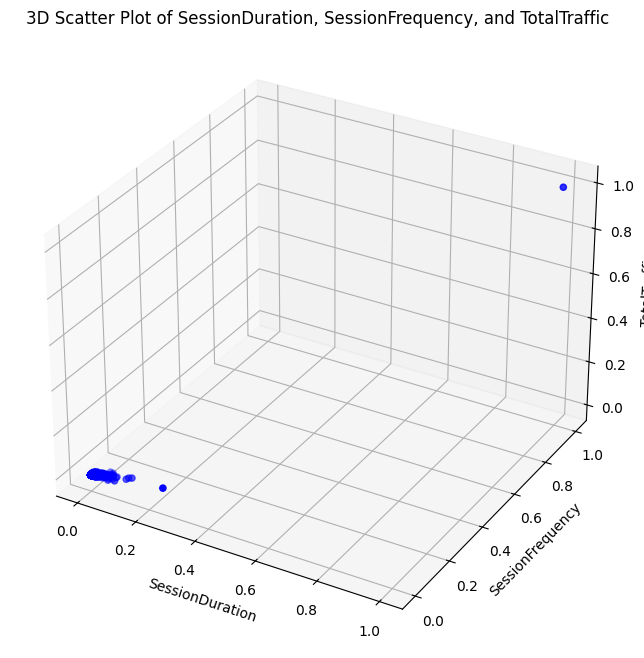

In [36]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_normalized['SessionDuration'], df_normalized['SessionFrequency'], df_normalized['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

### handle Outliers

In [43]:
processed_df = dc.handle_outliers(normalized_data, columns_to_normalize)

### plot after handling outliers

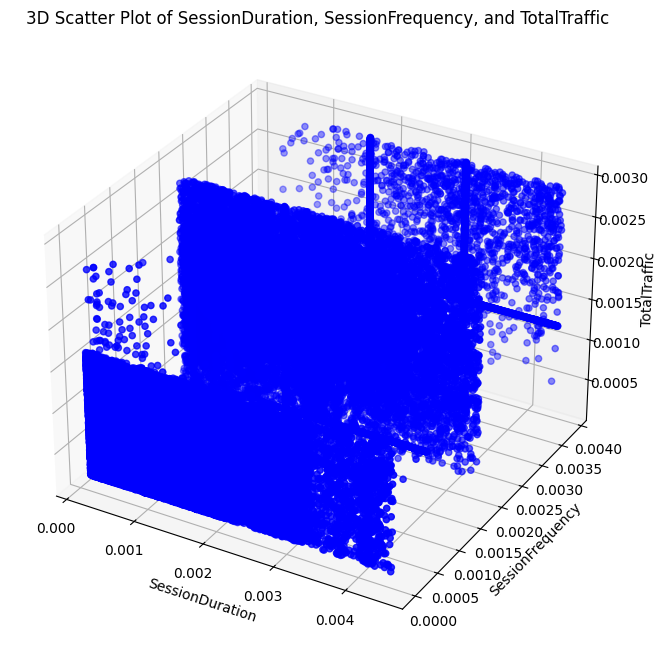

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(processed_df['SessionDuration'], processed_df['SessionFrequency'], processed_df['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

In [46]:
kmeans = KMeans(n_clusters=3, random_state=0) 
kmeans.fit(processed_df)

/home/misge/miniconda3/envs/tenx/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=0)